# Chapter 9: RNN, CNN

## 80. ID番号への変換

問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [165]:
# https://qiita.com/nymwa/items/4542b45837a10766890b

In [2]:
import random
import re
import string
import torch
import pandas as pd
import numpy as np

In [3]:
categories = ['b', 't', 'e', 'm']

In [4]:
train_df = pd.read_table('../data/news_aggregator/train.txt')
valid_df = pd.read_table('../data/news_aggregator/valid.txt')
test_df = pd.read_table('../data/news_aggregator/test.txt')

In [5]:
import re
import string

def tokenize(x):
    table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    x = x.translate(table).split()
    x = [w.lower() for w in x]
    return x

In [6]:
train_df['tokens'] = train_df['title'].map(tokenize)
valid_df['tokens'] = valid_df['title'].map(tokenize)
test_df['tokens'] = test_df['title'].map(tokenize)

In [7]:
def labelize(x):
    return torch.tensor(categories.index(x), dtype=torch.long)

In [8]:
train_df['label'] = train_df['category'].map(labelize)
valid_df['label'] = valid_df['category'].map(labelize)
test_df['label'] = test_df['category'].map(labelize)

In [9]:
from collections import Counter

In [10]:
counter = Counter([x for title in train_df['tokens'] for x in title])

In [11]:
vocab_in_train = [token for token, freq in counter.most_common() if freq > 1]

In [12]:
vocab_list = ['[UNK]'] + vocab_in_train
vocab_dict = {x:n for n, x in enumerate(vocab_list)}

In [13]:
def sent2ids(sent):
    return torch.tensor([vocab_dict[x if x in vocab_dict else '[UNK]'] for x in sent], dtype=torch.long)

In [14]:
train_df['tokens'][0]

['astrazeneca',
 'weighs',
 'on',
 'europe',
 'shares',
 'as',
 'it',
 'rejects',
 'pfizer',
 'bid']

In [15]:
sent2ids(train_df['tokens'][0])

tensor([ 368, 1377,    7,  219,   37,    8,   30, 1711,  260,  183])

In [16]:
def df2ids(x):
    return [sent2ids(sent) for sent in x]

In [17]:
train_df['tokens'][:5]

0    [astrazeneca, weighs, on, europe, shares, as, ...
1    [un, officials, want, better, flight, tracking...
2    [kim, kardashian, kim, kardashian, visits, wed...
3    [update, 1, ackman, asks, for, allergan, s, st...
4    [european, car, sales, jump, 7, 6, as, price, ...
Name: tokens, dtype: object

In [18]:
df2ids(train_df['tokens'])[:5]

[tensor([ 368, 1377,    7,  219,   37,    8,   30, 1711,  260,  183]),
 tensor([ 583,  717,  662,  607,  718, 2252,   18,  283,    5,  718, 1860]),
 tensor([  33,   27,   33,   27, 1712,  105, 4507]),
 tensor([   9,   13,  910, 1577,    6,  508,    2,    0,  563]),
 tensor([ 214,  426,   51,  403,  122,  132,    8,  457,  208,  335, 5702, 2253,
           25])]

## 86. 畳み込みニューラルネットワーク (CNN)

ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．

+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現

すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．

$$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
$$

ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．

最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．

$$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$$

最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．

$$
y = {\rm softmax}(W^{(yc)} c + b^{(y)})
$$

なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．

### CNNとは

参考：[Understanding Convolutional Neural Networks for NLP](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

![](https://tkengo.github.io/assets/img/understanding-convolutional-neural-networks-for-nlp/convolution_schematic.gif)


![](https://tkengo.github.io/assets/img/understanding-convolutional-neural-networks-for-nlp/convolutional-neural-network-overview.png)

- 画像処理
    - 位置普遍性（location invariance）
        - 位置を気にしなくてもよい
    - 構成性（compositionality）
        - 低レベルな特徴から高レベルな特徴へ
- NLPではn-gramより速い

![](https://tkengo.github.io/assets/img/understanding-convolutional-neural-networks-for-nlp/convolutional-neural-network-for-nlp-without-pooling.png)

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

In [20]:
cnn_vocab_list = ['[PAD]', '[UNK]'] + vocab_in_train
cnn_vocab_dict = {x:n for n, x in enumerate(cnn_vocab_list)}

In [21]:
def cnnsent2ids(sent):
    return torch.tensor([cnn_vocab_dict[x if x in cnn_vocab_dict else '[UNK]'] for x in sent], dtype=torch.long)

In [22]:
train_df['tokens'][0]

['astrazeneca',
 'weighs',
 'on',
 'europe',
 'shares',
 'as',
 'it',
 'rejects',
 'pfizer',
 'bid']

In [23]:
cnnsent2ids(train_df['tokens'][0])

tensor([ 369, 1378,    8,  220,   38,    9,   31, 1712,  261,  184])

In [24]:
def cnndf2ids(row):
    return [cnnsent2ids(sent) for sent in row]

In [25]:
x_train = cnndf2ids(train_df['tokens'])
x_valid = cnndf2ids(valid_df['tokens'])
x_test = cnndf2ids(test_df['tokens'])

In [26]:
t_train = list(train_df['label'])
t_valid = list(valid_df['label'])
t_test = list(test_df['label'])

In [27]:
x_train[:5]

[tensor([ 369, 1378,    8,  220,   38,    9,   31, 1712,  261,  184]),
 tensor([ 584,  718,  663,  608,  719, 2253,   19,  284,    6,  719, 1861]),
 tensor([  34,   28,   34,   28, 1713,  106, 4508]),
 tensor([  10,   14,  911, 1578,    7,  509,    3,    1,  564]),
 tensor([ 215,  427,   52,  404,  123,  133,    9,  458,  209,  336, 5703, 2254,
           26])]

In [28]:
class CNNData(Dataset):
    def __init__(self, source, target):
        self.source = source
        self.target = target
        self.lengths = torch.tensor([len(x) for x in source])
        self.size = len(source)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        return {
            'src': self.source[index],
            'trg': self.target[index],
            'lengths': self.lengths[index]
        }
        
    def collate(self, xs):
        max_seq_len = max([x['lengths'] for x in xs])
        src = [torch.cat([x['src'], torch.zeros(max_seq_len - x['lengths'], dtype=torch.long)], dim=-1) for x in xs]
        src = torch.stack(src)
        mask = [[1] * x['lengths'] + [0] * (max_seq_len - x['lengths']) for x in xs]
        mask = torch.tensor(mask, dtype=torch.long)
        return {
            'src': src,
            'trg': torch.tensor([x['trg'] for x in xs]),
            'mask': mask
        }

In [29]:
class Sampler(torch.utils.data.Sampler):
    def __init__(self, dataset, width, shuffle=False):
        self.dataset = dataset
        self.width = width
        self.shuffle = shuffle
        if not shuffle:
            self.indices = torch.arange(len(dataset))
        
    def __iter__(self):
        if self.shuffle:
            self.indices = torch.randperm(len(self.dataset))
        index = 0
        while index < len(self.dataset):
            yield self.indices[index:index+self.width]
            index += self.width

In [30]:
class DescendingSampler(Sampler):
    def __init__(self, dataset, width, shuffle=False):
        assert not shuffle
        super().__init__(dataset, width, shuffle)
        self.indices = self.indices[self.dataset.lengths[self.indices].argsort(descending=True)]

In [31]:
class MaxTokensSampler(Sampler):
    def __iter__(self):
        self.indices = torch.randperm(len(self.dataset))
        self.indices = self.indices[self.dataset.lengths[self.indices].argsort(descending=True)]
        for batch in self.generate_batches():
            yield batch

    def generate_batches(self):
        batches = []
        batch = []
        acc = 0
        max_len = 0
        for index in self.indices:
            acc += 1
            this_len = self.dataset.lengths[index]
            max_len = max(max_len, this_len)
            if acc * max_len > self.width:
                batches.append(batch)
                batch = [index]
                acc = 1
                max_len = this_len
            else:
                batch.append(index)
        if batch != []:
            batches.append(batch)
        random.shuffle(batches)
        return batches

In [32]:
def gen_loader(dataset, width, sampler=Sampler, shuffle=False, num_workers=8):
    return torch.utils.data.DataLoader(
        dataset, 
        batch_sampler = sampler(dataset, width, shuffle),
        collate_fn = dataset.collate,
        num_workers = num_workers,
    )

def gen_descending_loader(dataset, width, num_workers=0):
    return gen_loader(dataset, width, sampler = DescendingSampler, shuffle = False, num_workers = num_workers)

def gen_maxtokens_loader(dataset, width, num_workers=0):
    return gen_loader(dataset, width, sampler = MaxTokensSampler, shuffle = True, num_workers = num_workers)

In [33]:
train_dataset = CNNData(x_train, t_train)
valid_dataset = CNNData(x_valid, t_valid)
test_dataset = CNNData(x_test, t_test)

In [34]:
class CNN(nn.Module):
    def __init__(self, v_size, e_size, h_size, c_size, dropout=0.2):
        super().__init__()
        self.embed = nn.Embedding(v_size, e_size)
        self.conv = nn.Conv1d(e_size, h_size, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(h_size, c_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, batch):
        x = self.embed(batch['src'])
        x = self.dropout(x)
        x = self.conv(x.transpose(-1, -2))
        x = self.relu(x)
        x = self.dropout(x)
        x.masked_fill_(batch['mask'].unsqueeze(-2) == 0, -1e4)
        x = F.max_pool1d(x, x.size(-1)).squeeze(-1)
        x = self.fc(x)
        
        return x

In [35]:
loader = gen_loader(test_dataset, 10, DescendingSampler, False)

In [36]:
model = CNN(len(cnn_vocab_list), 300, 128, 4)

In [37]:
model(iter(loader).next()).argmax(dim=-1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## 87. 確率的勾配降下法によるCNNの学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [39]:
device

device(type='cuda', index=0)

In [40]:
class Task:
    def __init__(self):
        self.criterion = nn.CrossEntropyLoss()

    def train_step(self, model, batch):
        model.zero_grad()
        loss = self.criterion(model(batch), batch['trg'])
        loss.backward()
        return loss.item()

    def valid_step(self, model, batch):
        with torch.no_grad():
            loss = self.criterion(model(batch), batch['trg'])
        return loss.item()

In [41]:
class Trainer:
    def __init__(self, model, loaders, task, optimizer, max_iter, plotter, device = None):
        self.model = model
        self.model.to(device)
        self.train_loader, self.valid_loader, self.predict_train_loader, self.predict_valid_loader = loaders
        self.task = task
        self.optimizer = optimizer
        self.max_iter = max_iter
        self.device = device
        self.plot = plotter

    def send(self, batch):
        for key in batch:
            batch[key] = batch[key].to(self.device)
        return batch

    def train_epoch(self):
        self.model.train()
        acc = 0
        for n, batch in enumerate(self.train_loader):
            batch = self.send(batch)
            acc += self.task.train_step(self.model, batch)
            self.optimizer.step()
        return acc / n

    def valid_epoch(self):
        self.model.eval()
        acc = 0
        for n, batch in enumerate(self.valid_loader):
            batch = self.send(batch)
            acc += self.task.valid_step(self.model, batch)
        return acc / n
    
    def infer(self, batch):
        self.model.eval()
        batch = self.send(batch)
        return self.model(batch).argmax(dim=-1).item()
    
    def predict(self, loader):
        pred = []
        true = []
        for batch in loader:
            pred.append(self.infer(batch))
            true.append(batch['trg'].item())
        return pred, true

    def accuracy(self, true, pred):
        return np.mean([t == p for t, p in zip(true, pred)])
    
    def train_accuracy(self):
        pred, true = self.predict(self.predict_train_loader)
        return self.accuracy(pred, true)
        
    def valid_accuracy(self):
        pred, true = self.predict(self.predict_valid_loader)
        return self.accuracy(pred, true)

    def train(self):
        train_loss_lst = []
        valid_loss_lst = []
        train_acc_lst = []
        valid_acc_lst = []
        for epoch in range(self.max_iter):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            train_accuracy = self.train_accuracy()
            valid_accuracy = self.valid_accuracy()
            
            train_loss_lst.append(train_loss)
            valid_loss_lst.append(valid_loss)
            train_acc_lst.append(train_accuracy)
            valid_acc_lst.append(valid_accuracy)
            
            self.plot.update([train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst])
            print('epoch {}, train_loss:{:.5f}, valid_loss:{:.5f}'.format(epoch, train_loss, valid_loss))
            print('\t train_accuracy:{:.5f}, valid_accuracy:{:.5f}'.format(train_accuracy, valid_accuracy))

In [42]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

class Plotter:
    def __init__(self):
        self.fig = plt.figure(figsize=(16, 8))
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax2 = self.fig.add_subplot(1, 2, 2, sharey=self.ax1)
        self.ax1.set_xlabel('Epoch')
        self.ax1.set_ylabel('Loss')
        self.ax2.set_xlabel('Epoch')
        self.ax2.set_ylabel('Accuracy')
        
    def update(self, data):
        
        clear_output(wait=True)
        
        train_loss, valid_loss, train_accuracy, valid_accuracy = data
        epoch = len(train_loss)
    
        line1, = self.ax1.plot(range(1, epoch + 1), train_loss, label='train', color='royalblue')
        line2, = self.ax1.plot(range(1, epoch + 1), valid_loss, label='valid', color='darkorange')

        line3, = self.ax2.plot(range(1, epoch + 1), train_accuracy, label='train', color='royalblue')
        line4, = self.ax2.plot(range(1, epoch + 1), valid_accuracy, label='valid', color='darkorange')
        
        plt.legend()

        display(self.fig)

        line1.remove()
        line2.remove()
        line3.remove()
        line4.remove()
        
    def close(self):
        plt.close(self.fig)

In [43]:
class Predictor:
    def __init__(self, model, loader, device=None):
        self.model = model
        self.loader = loader
        self.device = device

    def send(self, batch):
        for key in batch:
            batch[key] = batch[key].to(self.device)
        return batch

    def infer(self, batch):
        self.model.eval()
        batch = self.send(batch)
        return self.model(batch).argmax(dim=-1).item()

    def predict(self):
        lst = []
        for batch in self.loader:
            lst.append(self.infer(batch))
        return lst

In [44]:
from gensim.models import KeyedVectors 
vectors = KeyedVectors.load_word2vec_format('../data/google_news.bin.gz', binary=True)

In [45]:
def init_cnn_embed(embed):
    for i, token in enumerate(cnn_vocab_list):
        if token in vectors:
            embed.weight.data[i] = torch.from_numpy(vectors[token])
    return embed

In [46]:
def accuracy(true, pred):
    return np.mean([t == p for t, p in zip(true, pred)])

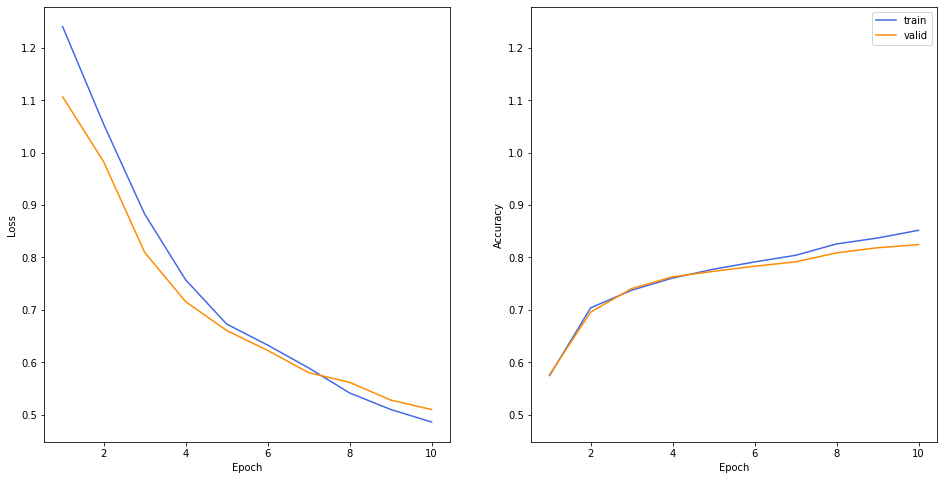

epoch 9, train_loss:0.48593, valid_loss:0.50982
	 train_accuracy:0.85186, valid_accuracy:0.82459


In [47]:
model = CNN(len(cnn_vocab_dict), 300, 128, 4)
init_cnn_embed(model.embed)
loaders = (
    gen_maxtokens_loader(train_dataset, 4000),
    gen_descending_loader(valid_dataset, 32),
    gen_loader(train_dataset, 1),
    gen_loader(valid_dataset, 1)
)
task = Task()
plotter = Plotter()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
trainer = Trainer(model, loaders, task, optimizer, 10, plotter, device)
trainer.train()
plotter.close()

In [48]:
# predictor = Predictor(model, gen_loader(train_dataset, 1), device)
# pred = predictor.predict()
# print('train accuracy', accuracy(t_train, pred))

predictor = Predictor(model, gen_loader(test_dataset, 1), device)
pred = predictor.predict()
print('test accuracy', accuracy(t_test, pred))

test accuracy 0.8298350824587706


## 89. 事前学習済み言語モデルからの転移学習

事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

In [49]:
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification

In [50]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [51]:
def tokenize_bert(x):
    return torch.tensor(tokenizer.encode(x, max_length=512, truncation=True), dtype=torch.long)

In [52]:
x_train = list(train_df['title'].map(tokenize_bert))
x_valid = list(valid_df['title'].map(tokenize_bert))
x_test = list(test_df['title'].map(tokenize_bert))

In [53]:
class BertDataset(CNNData):
    def collate(self, xs):
        max_seq_len = max([x['lengths'] for x in xs])
        src = [torch.cat([x['src'], torch.zeros(max_seq_len - x['lengths'], dtype=torch.long)], dim=-1) for x in xs]
        src = torch.stack(src)
        mask = [[1] * x['lengths'] + [0] * (max_seq_len - x['lengths']) for x in xs]
        mask = torch.tensor(mask, dtype=torch.long)
        return {
            'src':src,
            'trg':torch.tensor([x['trg'] for x in xs]),
            'mask':mask,
        }

In [54]:
bert_train_dataset = BertDataset(x_train, t_train)
bert_valid_dataset = BertDataset(x_valid, t_valid)
bert_test_dataset = BertDataset(x_test, t_test)

In [55]:
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        config = BertConfig.from_pretrained('bert-base-cased', num_labels=4)
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-cased', config=config)

    def forward(self, batch):
        x = self.bert(batch['src'], attention_mask=batch['mask'])
        return x[0]

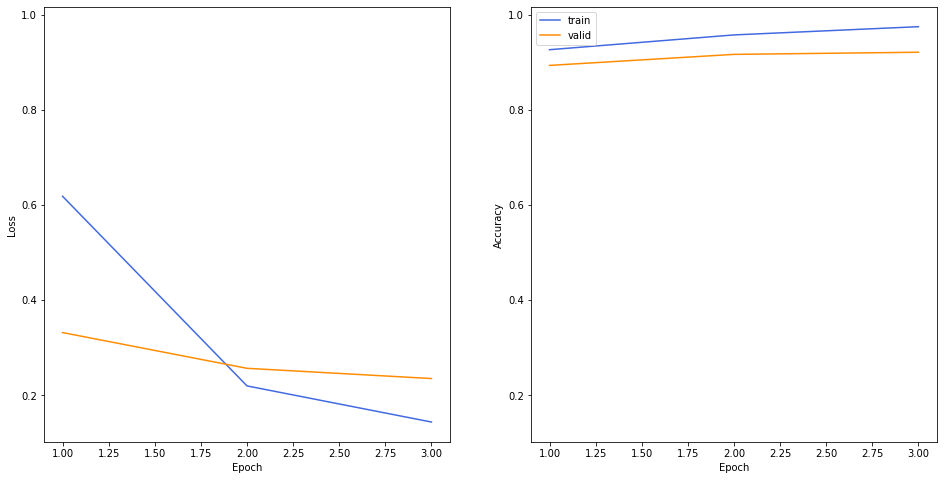

epoch 2, train_loss:0.14357, valid_loss:0.23513
	 train_accuracy:0.97582, valid_accuracy:0.92204


In [ ]:
model = BertClassifier()
loaders = (
    gen_maxtokens_loader(bert_train_dataset, 1000),
    gen_descending_loader(bert_valid_dataset, 32),
    gen_loader(bert_train_dataset, 1),
    gen_loader(bert_valid_dataset, 1)
)
task = Task()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
plotter = Plotter()
trainer = Trainer(model, loaders, task, optimizer, 5, plotter, device)
trainer.train()
plotter.close()

In [103]:
# predictor = Predictor(model, gen_loader(bert_train_dataset, 1), device)
# pred = predictor.predict()
# print('train accuracy', accuracy(t_train, pred))

predictor = Predictor(model, gen_loader(bert_test_dataset, 1), device)
pred = predictor.predict()
print('test accuracy', accuracy(t_test, pred))

test accuracy 0.9557721139430285
